In [50]:
import numpy as np
import os
import pysynphot as s
import pandas as pd
import matplotlib.pyplot as plt


def photometry(filters_path, filters_list, specs_path, specs_list, telescope_area, results_path, confidence=0.6,
               plot=False, save=False):
    """

    :param filters_path: add the path to your filters response files -- e.g '/home/user/Documents/Filters'
    :param filters_list: add the path and name of your filters' list
    -- e.g '/home/user/Documents/filters_list.txt'
    Inside this list you should have all the filters' response files that you are going to use
    -- e.g.:
    uSDSS.txt
    gSDSS.txt
    rSDSS,txt
    iSDSS.txt
    zSDSS.txt
    You can create it in your command line by doing the following command:
    $ ls /home/user/Documents/Filters >> /home/user/Documents/filters_list.txt
    :param specs_path: add the path to your spectra files -- e.g '/home/user/Documents/Specs'
    :param specs_list: similar to the filters_list
    :param telescope_area: the default parameter is 4400 which is the J-PAS T80 M1 effective area in cm^2.
    Set it as you wish given your telescope.
    :param results_path: add the path where you would like to save your results. It is only obligatory if you set
    plot=True
    :param confidence: the confidence that you would like to add in order to calculate a simulated photometry.
    This is important for the photometry of the borders of the spectra. This will limit the calculation of the
    photometry in terms of the wavelength range. If the filter occupies less than X% of your spectrum wavelength range,
    it will generate an error value (-999), but if it occupies more than X% it will do the convolution the filter with
    the spectrum. The default value is 60% (0.6), but you can change this at your will.
    :param plot: if you want to plot the results and save them, please set 'plot=True'. If not, please set 'plot=False'.
    The default is false. Warning: please be careful with the name you would like to use to save your results.
    This function uses the spectrum file to generate the results. The shape of the file is with the SDSS spectra
    identifiers: plate, mjd, fiberid -- e.g. 1019.52707.261.txt --- If this is not the case, please change line
    :param save: if you want to save the results, please set 'save=True'. If not, please set 'save=False'. The default
    is false.
    :return:
    """

    # Setting the telescope area; the default parameter is the T80 M1 effective area in cm^2 ---------------------------
    if telescope_area==None:
        s.setref(area=4400)
    else:
        s.setref(area=telescope_area)

    # Reading your files -----------------------------------------------------------------------------------------------
    filters_list = np.loadtxt(filters_list, dtype=str)
    specs_list   = np.loadtxt(specs_list, dtype=str)

    # Simulating photometry for your spectra using the selected survey filters -----------------------------------------
    count = 0
    for each_spectrum in specs_list:
        print each_spectrum
        filter_name     = []
        photometry      = []
        photometry_flam = []
        lambda_eff      = []
        for filters in filters_list:
            # saving an array with the filters names -------------------------------------------------------------------
            filter_name_i          = filters.split('.')[0]
            filter_name.append(filter_name_i)

            # convolution ----------------------------------------------------------------------------------------------
            filter_bandpass = s.FileBandpass(os.path.join(filters_path, filters))
            spectrum         = s.FileSpectrum(os.path.join(specs_path, each_spectrum))             # the entire spectrum
            index            = np.where(spectrum.flux > 0)            # selecting only the positive part of the spectrum
            spectrum2        = s.ArraySpectrum(wave=spectrum.wave[index], flux=spectrum.flux[index],
                                                    fluxunits=spectrum.fluxunits, waveunits=spectrum.waveunits)
            binset = filter_bandpass.wave                        # this is very very important! don't change this unless
                                                                        # you are absolutely sure of what you are doing!
            ## convolved photometry ------------------------------------------------------------------------------------
            photometry_i = s.Observation(spectrum2, filter_bandpass, binset=binset, force='extrap')

            ## effective wavelength ------------------------------------------------------------------------------------
            lambda_eff_i = photometry_i.efflam()
            lambda_eff.append(lambda_eff_i)

            ## checking if the simulated photometry is "virtual" and letting those away --------------------------------
            if filter_bandpass.wave.min() < spectrum2.wave.min():
                if filter_bandpass.wave.max() - spectrum2.wave.min() > confidence * (filter_bandpass.wave.max() -
                                                                                  filter_bandpass.wave.min()):
                    photometry.append(photometry_i.effstim('abmag'))
                    photometry_flam_i = photometry_i.effstim('flam')
                    photometry_flam.append(photometry_flam_i)

                else:
                    new_photometry_i = -999
                    photometry.append(new_photometry_i)
                    photometry_flam.append(new_photometry_i)

            elif filter_bandpass.wave.max() > spectrum2.wave.max():
                if spectrum2.wave.max() - filter_bandpass.wave.min() > confidence * (filter_bandpass.wave.max() -
                                                                                  filter_bandpass.wave.min()):
                    photometry.append(photometry_i.effstim('abmag'))
                    photometry_flam_i = photometry_i.effstim('flam')
                    photometry_flam.append(photometry_flam_i)

                else:
                    new_photometry_i = -999
                    photometry.append(new_photometry_i)
                    photometry_flam.append(new_photometry_i)

            else:
                photometry.append(photometry_i.effstim('abmag'))
                photometry_flam_i = photometry_i.effstim('flam')
                photometry_flam.append(photometry_flam_i)

        count = count+1

        # putting the iterated items into arrays -----------------------------------------------------------------------
        filter_name       = np.array(filter_name)            # name of each filter
        photometry        = np.array(photometry)             # in magnitudes
        lambda_eff        = np.array(lambda_eff)             # effective wavelengths of the filters
        photometry_flam   = np.array(photometry_flam)        # in flux of lambda
        photometry_fnu    = 10**(-0.4*(photometry + 48.60))  # in flux of nu

        print photometry

        if plot==False:
            return filter_name, photometry, lambda_eff, photometry_flam, photometry_fnu
        else:

        # plots --------------------------------------------------------------------------------------------------------
            plot01 = plt.plot(spectrum2.wave, spectrum2.flux, '-')
            plot02 = plt.plot(lambda_eff[[photometry_flam!=-999]], photometry_flam[[photometry_flam!=-999]], 'o')
            plt.title(r"%s" % each_spectrum, size='15')
            plt.savefig(os.path.join(results_path, str(count)+'.png'), dpi = 100)
            plt.show()

        if save==False:
            continue
        else:

        # saving the newley calculated photometry ----------------------------------------------------------------------
            galaxy_simulation_abmag = np.vstack((filter_name, photometry))
            galaxy_simulation_abmag = pd.DataFrame(galaxy_simulation_abmag)
            galaxy_simulation_abmag.to_csv(os.path.join(results_path, str(count)+'_abmag.csv'), sep=',', header=None,
                                           index=False)
            galaxy_simulation_fnu = np.vstack((filter_name, photometry_fnu))
            galaxy_simulation_fnu = pd.DataFrame(galaxy_simulation_fnu)
            galaxy_simulation_fnu.to_csv(os.path.join(results_path, str(count)+'_fnu.csv'), sep=',', header=None,
                                         index=False)
    return filter_name, photometry, lambda_eff, photometry_flam, photometry_fnu


0443.51873.152.txt
[  17.76891069   16.37237139   19.37895719   19.11349581   18.52304395
   18.31447101   17.55542763   16.71539918   16.87058662   19.66330558
 -999.        ]


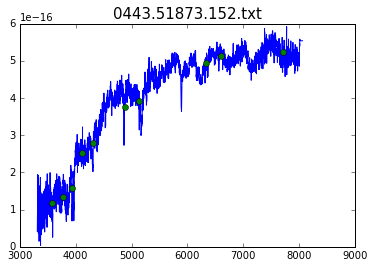

1019.52707.261.txt
[  14.95650508   14.37529668 -999.           15.18154152   15.08287191
   15.03766283   14.95053298   14.05442631   14.56737356 -999.         -999.        ]


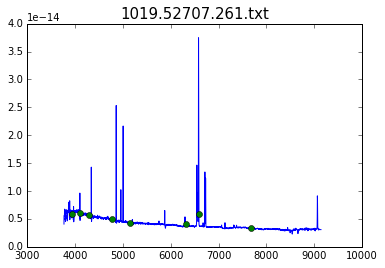

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
[  17.02435338 -999.           18.93644109   18.57315147   15.42075101
   18.67473104   18.57103682 -999.       

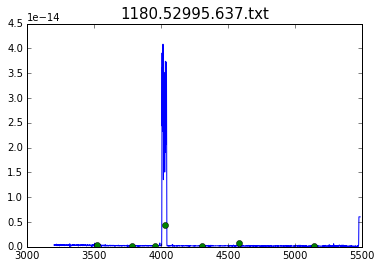

1665.52976.514.txt
[  15.19626288   13.94305412   17.00841599   16.56796407   15.985144
   15.72499862   15.01864104   14.23158777   14.36243295 -999.         -999.        ]


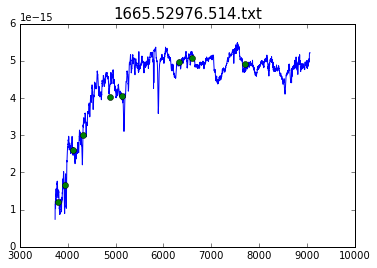

2231.53816.545.txt
[  14.84449676   14.23656917   15.10938803   15.0600856    15.02217003
   14.96476897   14.74064133   14.40985028   14.48648228 -999.         -999.        ]


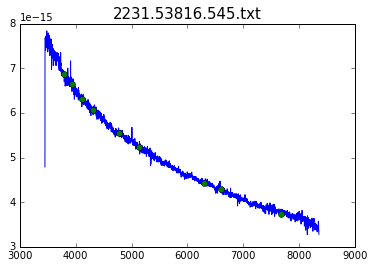

In [51]:
my_photo = photometry(filters_path = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/JPLUS_SDSS_filters', 
                      filters_list = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/jplus_filters_list.txt', 
                      specs_path = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Specs', 
                      specs_list = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/specslist2.txt', 
                      telescope_area = 4400,
                      results_path = '/home/mldantas/Downloads/test', plot=True, save=True)

In [52]:
import photometry_simulation as ps

0443.51873.152.txt
[  17.76891069   16.37237139   19.37895719   19.11349581   18.52304395
   18.31447101   17.55542763   16.71539918   16.87058662   19.66330558
 -999.        ]


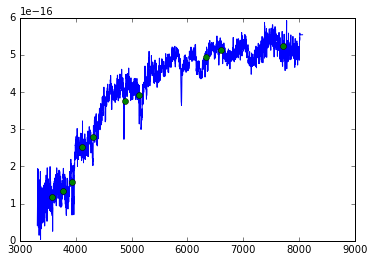

1019.52707.261.txt
[  14.95650508   14.37529668   15.41770556   15.18154152   15.08287191
   15.03766283   14.95053298   14.05442631   14.56737356 -999.
   14.12531963]


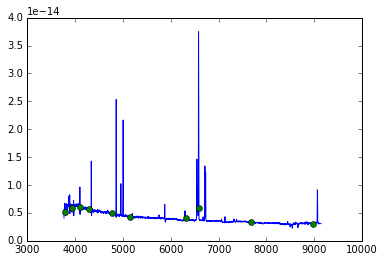

1180.52995.637.txt
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
Warning, 9 of 6001 bins contained negative fluxes; they have been set to zero.
[  17.02435338 -999.           18.93644109   18.57315147   15.42075101
   18.67473104   18.57103682 -999.       

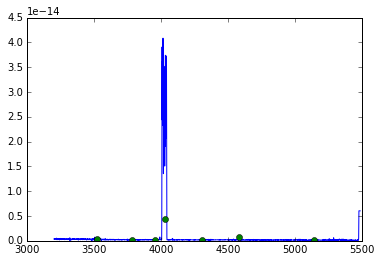

1665.52976.514.txt
[  15.19626288   13.94305412   17.00841599   16.56796407   15.985144
   15.72499862   15.01864104   14.23158777   14.36243295 -999.
   13.62131201]


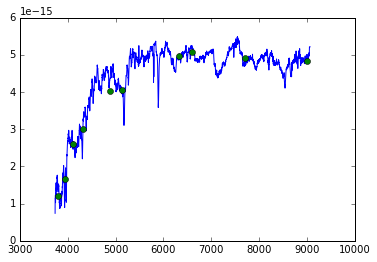

2231.53816.545.txt
[  14.84449676   14.23656917   15.10938803   15.0600856    15.02217003
   14.96476897   14.74064133   14.40985028   14.48648228   15.29214332
 -999.        ]


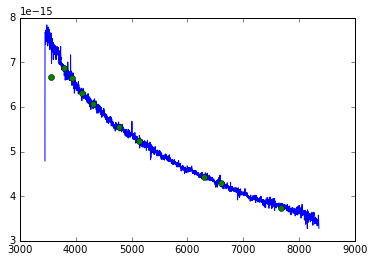

In [53]:
my_photo = ps.photometry(filters_path = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/JPLUS_SDSS_filters', 
                      filters_list = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Filters/jplus_filters_list.txt', 
                      specs_path = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/Specs', 
                      specs_list = '/home/mldantas/Dropbox/DoutoradoIAG/Challenge/Sanity_Check/specslist2.txt', 
                      telescope_area = 4400,
                      results_path = '/home/mldantas/Downloads/test', plot=True, save=True)

In [56]:
ps??